## import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import viridis
from matplotlib.cm import ScalarMappable
import matplotlib
from matplotlib.widgets import Slider,CheckButtons
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import savgol_filter,find_peaks
from tqdm import tqdm

import time
from collections import Counter
from pandas import Series

from impedance.visualization import plot_nyquist, plot_residuals, plot_bode
from impedance import preprocessing
from impedance.validation import linKK
from impedance.models.circuits import CustomCircuit

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor


## import EIS data, I, T as input and Q_rlt as output 

In [2]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
db = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

EISdata1 = Series()
EISdata2 = Series()

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)
    
    
    ##formation phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.form_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.form_geis WHERE `state of charge`=0'
    cellx_df_form = pd.read_sql(sql, Connection)
  
    
    for f in pd.unique(cellx_df_form['freq/Hz']):
        Z= cellx_df_form[cellx_df_form['freq/Hz']==f][['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_form = Z
            Temp = EISdata_form
        else:
            EISdata_form = pd.merge(Z, Temp)
            Temp = EISdata_form
    EISdata_form.insert(EISdata_form.shape[1],'I(uA)',i)
        
    
    ##cycling phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.cyc_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis' 
    cellx_df_cyc = pd.read_sql(sql, Connection)
    
    for f in pd.unique(cellx_df_cyc['freq/Hz']):
        Z_f = cellx_df_cyc[cellx_df_cyc['freq/Hz']==f]
        Z = Z_f[['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_cyc = Z
            Temp = EISdata_cyc
        else:
            EISdata_cyc = pd.merge(Z, Temp)
            Temp = EISdata_cyc
    EISdata_cyc.insert(EISdata_cyc.shape[1],'I(uA)',i)
    
    EISdata_pre = pd.concat([EISdata_form, EISdata_cyc])
      
    
    
    ##insert SOH data
    sql = 'SELECT `Q_relative`,`cycle_Nr` FROM ' +cell+ '.capacity'
    Q_rlt = pd.read_sql(sql, Connection)
    Q_rlt10 = pd.read_sql(sql, Connection)
    Q_rlt10['cycle_Nr'] = Q_rlt['cycle_Nr']-10
    
    EISdata_pre1 = pd.merge(EISdata_pre, Q_rlt)
    EISdata_pre2 = pd.merge(EISdata_pre, Q_rlt10, how='inner')
    
    ##insert SoH_in_10cycles
    
    ##combine two phases
    EISdata1 = pd.concat([EISdata1, EISdata_pre1])
    EISdata2 = pd.concat([EISdata2, EISdata_pre2])
    


C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EISdata1 = Series()
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EISdata2 = Series()
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_i = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df_form = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_i = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df_cyc = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_2244\382656490.py:6

In [3]:
EISdata2

,0,cycle_Nr,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,Re(Z)0.0325963,-Im(Z)0.0325963,...,Re(Z)3061.0,-Im(Z)3061.0,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0,I(uA),Q_relative
0,NaN,1.0,48852.200,46573.100,39784.600,41140.600,41164.000,38890.600,38284.100,33659.900,...,1052.980,1524.2000,780.681,1205.8100,576.129,936.6760,20.1169,672.4060,20.0,0.76
1,NaN,2.0,4262.660,744.727,4109.630,680.813,3915.340,646.593,3753.190,610.109,...,539.758,373.8830,440.624,342.6310,352.459,305.1430,281.6410,268.2390,20.0,0.72
2,NaN,3.0,1475.700,466.609,1343.660,418.363,1274.420,371.091,1175.120,330.920,...,197.916,72.8279,178.468,73.8025,157.575,72.0772,133.8640,68.9481,20.0,0.73
3,NaN,4.0,903.619,321.803,836.947,268.775,776.234,249.611,724.889,213.158,...,133.406,47.5855,120.451,46.9005,107.645,44.2770,94.0251,41.8847,20.0,0.68
4,NaN,5.0,860.372,306.783,787.428,257.149,740.479,232.201,687.780,198.357,...,133.995,50.1709,120.529,48.6607,107.826,45.6482,95.3007,40.9052,20.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,NaN,41.0,3160.940,870.888,2957.000,781.214,2852.320,722.371,2659.910,648.622,...,336.675,175.2110,292.973,163.0000,252.437,150.0290,217.8350,141.1610,200.0,0.46
14,NaN,51.0,3309.360,928.158,3085.890,787.140,2927.600,746.442,2752.720,658.180,...,341.469,179.8540,297.738,167.1200,255.368,153.8190,221.8240,135.8220,200.0,0.45
15,NaN,61.0,3442.830,950.003,3282.840,851.159,3065.370,748.695,2910.610,695.747,...,359.744,196.1240,311.267,181.9630,265.472,166.5370,218.7300,150.0420,200.0,0.44
16,NaN,71.0,3625.640,981.726,3414.990,844.923,3240.280,815.402,3060.190,721.606,...,367.717,204.1460,317.095,188.5900,270.461,172.2550,232.0250,151.7020,200.0,0.44


## Or import the data directly from the csv files

In [4]:
EISdata1 = pd.read_csv('EISdata1_SoC0_Cyc1to100.csv')
EISdata2 = pd.read_csv('EISdata2_SoC0_Cyc10to100.csv')

# Machine Learning Modeling

## Diagnose models

In [5]:
# split datasets into train, cv and test for diagnose
UD_train, UD_temp = train_test_split(EISdata1.loc[EISdata1['cycle_Nr'] > 4], test_size=0.2, random_state=42)
UD_cv, UD_test = train_test_split(UD_temp, test_size=0.5, random_state=42)

# define process_data function
def preprocess_data(data):
    X_pre = np.log10(data.loc[:, 'Re(Z)0.235159':'-Im(Z)10001.0'])
    X = pd.concat([X_pre, np.sqrt(data['I(uA)'])], axis=1)
    y = data['Q_relative']
    return X, y

# prepare datasets
X_train, y_train = preprocess_data(UD_train)
X_cv, y_cv = preprocess_data(UD_cv)
X_test, y_test = preprocess_data(UD_test)

In [6]:
# Bayesian Regression
start_time = time.time()

poly_reg =Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("std_scaler",StandardScaler()),
    ("feature_selection", SelectFromModel(BayesianRidge())),
    ("bayesian_regression",BayesianRidge())    
])

poly_reg.fit(X_train,y_train)

# Model evaluation
train_score = poly_reg.score(X_train, y_train)
cv_score = np.mean(cross_val_score(poly_reg, X_cv, y_cv, cv=5))

# param=poly_reg.get_params(X_train,y_train)
predict_train=poly_reg.predict(X_train)
predict_cv=poly_reg.predict(X_cv)
predict_test, predict_std=poly_reg.predict(X_test,return_std=True)
y_pre_std = pd.DataFrame(data={'y_t':y_test,'y_pre':predict_test,'y_std':predict_std})

end_time = time.time()
run_time1 = end_time - start_time

print("running time：", run_time1, "seconds")

running time： 33.59625053405762 seconds


In [7]:
X_poly = poly_reg.named_steps["poly"].get_feature_names_out()
X_scl = poly_reg.named_steps["std_scaler"].get_feature_names_out()
X_slt = poly_reg.named_steps["feature_selection"].get_feature_names_out()
coef = poly_reg.named_steps["bayesian_regression"].coef_

d1 = {'coef':coef,'X_scale':X_slt}
d2 = {'physic_names':X_poly,'X_scale':X_scl}
FS = pd.DataFrame(data=d1) # FS for feature selection
FA = pd.DataFrame(data=d2) # FA for features all
model_features = pd.merge(FS, FA, how = 'inner') 
model_features['abs_coef'] = np.absolute(model_features['coef']) 
model_features.sort_values('abs_coef',ascending=False)[0:20]

,coef,X_scale,physic_names,abs_coef
7,-0.010617,x8,-Im(Z)0.768341,0.010617
13583,0.010549,x34217,-Im(Z)10001.0^2 I(uA),0.010549
13585,-0.010308,x34219,I(uA)^3,0.010308
320,-0.010208,x436,-Im(Z)0.768341^2,0.010208
237,-0.009509,x335,-Im(Z)0.516884 -Im(Z)0.768341,0.009509
19,0.009097,x24,-Im(Z)18.077,0.009097
15,0.008918,x20,-Im(Z)8.21194,0.008918
1020,-0.008853,x1520,-Im(Z)286.568 I(uA),0.008853
1066,-0.008821,x1590,-Im(Z)630.738 I(uA),0.008821
235,-0.008754,x333,-Im(Z)0.516884^2,0.008754


<IPython.core.display.Javascript object>


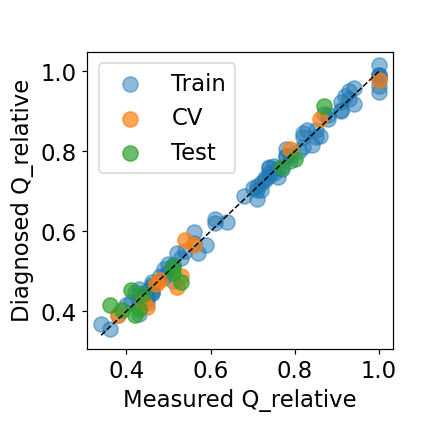

In [8]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train, s=100, marker='o',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv, s=100, marker='o', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test, s=100, marker='o', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [9]:
# Neural Network

start_time = time.time()

poly_reg2 =Pipeline([
    ("poly", PolynomialFeatures(degree=1)),
    ("std_scaler",StandardScaler()),
    ("mlp_regress",MLPRegressor(solver = 'lbfgs',hidden_layer_sizes=[80,50,50,50],activation='relu',alpha=0.0001, max_iter=10000))
])

poly_reg2.fit(X_train,y_train)

train_score2 = poly_reg2.score(X_train, y_train)
cv_score2 = np.mean(cross_val_score(poly_reg2, X_cv, y_cv, cv=5))

predict_train2 = poly_reg2.predict(X_train)
predict_cv2 = poly_reg2.predict(X_cv)
predict_test2  = poly_reg2.predict(X_test)

end_time = time.time()
run_time2 = end_time - start_time

print("running time：", run_time2, "seconds")

running time： 0.5936729907989502 seconds


<IPython.core.display.Javascript object>


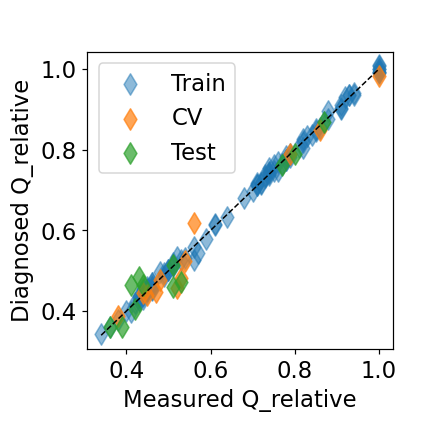

In [10]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train2, s=100, marker='d', alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv2, s=100, marker='d', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test2, s=100, marker='d', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [11]:
# Gaussian Process Regression
start_time = time.time()

poly_reg3 =Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("std_scaler",StandardScaler()),
#     ("feature_selection", SelectFromModel(BayesianRidge())),
    ("GaussianProcess_regression",GaussianProcessRegressor(kernel=1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
                                                           n_restarts_optimizer=9))    
])

poly_reg3.fit(X_train,y_train)

train_score3 = poly_reg3.score(X_train, y_train)
cv_score3 = np.mean(cross_val_score(poly_reg3, X_cv, y_cv, cv=5))

# param=poly_reg.get_params(X_train,y_train)
predict_train3=poly_reg3.predict(X_train)
predict_cv3 = poly_reg3.predict(X_cv)
predict_test3, predict_std3=poly_reg3.predict(X_test,return_std=True)
y_pre_std3 = pd.DataFrame(data={'y_t':y_test,'y_pre':predict_test3,'y_std':predict_std3})

end_time = time.time()
run_time3 = end_time - start_time

print("running time：", run_time3, "seconds")

C:\Users\b.zhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\b.zhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\b.zhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn

running time： 13.977792263031006 seconds


<IPython.core.display.Javascript object>


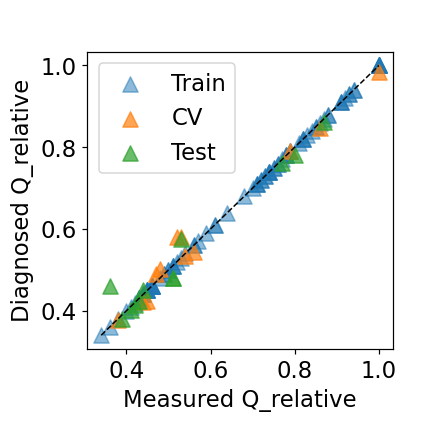

In [12]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train3, s=100, marker='^',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv3, s=100, marker='^', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test3, s=100, marker='^', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [13]:
# Decision Tree
start_time = time.time()

poly_tree = Pipeline([
    ("poly", PolynomialFeatures(degree=1)),
    ("std_scaler", StandardScaler()),
    ("feature_selection", SelectFromModel(DecisionTreeRegressor())),
    ("decision_tree", DecisionTreeRegressor(ccp_alpha=0.0001))    
])

# Fit the pipeline on training data
poly_tree.fit(X_train, y_train)

train_score4 = poly_tree.score(X_train, y_train)
cv_score4 = np.mean(cross_val_score(poly_tree, X_cv, y_cv, cv=5))

# Predict on training and test data
predict_train4 = poly_tree.predict(X_train)
predict_cv4 = poly_tree.predict(X_cv)
predict_test4 = poly_tree.predict(X_test)

end_time = time.time()
run_time4 = end_time - start_time

print("running time：", run_time4, "seconds")

running time： 0.03119802474975586 seconds


<IPython.core.display.Javascript object>


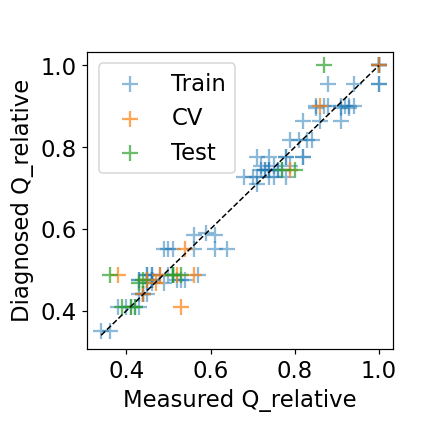

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train4, s=100, marker='+',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv4, s=100, marker='+', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test4, s=100, marker='+', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [16]:
print("MSE_train:",metrics.mean_squared_error(y_train, predict_train) ,
      metrics.mean_squared_error(y_train, predict_train2),
      metrics.mean_squared_error(y_train, predict_train3),
      metrics.mean_squared_error(y_train, predict_train4))
print("MSE_CV:",mean_squared_error(y_cv, predict_cv),
      mean_squared_error(y_cv, predict_cv2),
      mean_squared_error(y_cv, predict_cv3),
      mean_squared_error(y_cv, predict_cv4))
print("MSE_test:",metrics.mean_squared_error(y_test, predict_test),
      metrics.mean_squared_error(y_test, predict_test2),
      metrics.mean_squared_error(y_test, predict_test3),
      metrics.mean_squared_error(y_test, predict_test4))


MSE_train: 0.00029705734415578144 6.750675901682312e-05 1.9453916266461462e-16 0.0010554740338164254
MSE_CV: 0.0008379727697620439 0.0008936149877295647 0.0007281467893645888 0.00311285294495885
MSE_test: 0.001012820157617326 0.0011386829882951044 0.0012637881366491484 0.0035776081532921827


In [17]:
print("MAE_train:", mean_absolute_error(y_train, predict_train) ,
      mean_absolute_error(y_train, predict_train2),
      mean_absolute_error(y_train, predict_train3),
      mean_absolute_error(y_train, predict_train4))
print("MAE_CV:",mean_absolute_error(y_cv, predict_cv),
      mean_absolute_error(y_cv, predict_cv2),
      mean_absolute_error(y_cv, predict_cv3),
      mean_absolute_error(y_cv, predict_cv4))
print("MAE_test:",mean_absolute_error(y_test, predict_test),
      mean_absolute_error(y_test, predict_test2),
      mean_absolute_error(y_test, predict_test3),
      mean_absolute_error(y_test, predict_test4))
print("R2:", r2_score(y_test, predict_test),
     r2_score(y_test, predict_test2),
     r2_score(y_test, predict_test3),
     r2_score(y_test, predict_test4))

MAE_train: 0.013860915883727003 0.0060415679937919796 8.49841759826927e-09 0.02533272946859904
MAE_CV: 0.023030020893967287 0.02156201932835745 0.021018852281129884 0.03906712962962966
MAE_test: 0.025974936722652154 0.025870648410193948 0.024033298800115826 0.04426388888888891
R2: 0.9641972450174551 0.9597480483320662 0.9553256353894645 0.8735330974877076


<IPython.core.display.Javascript object>


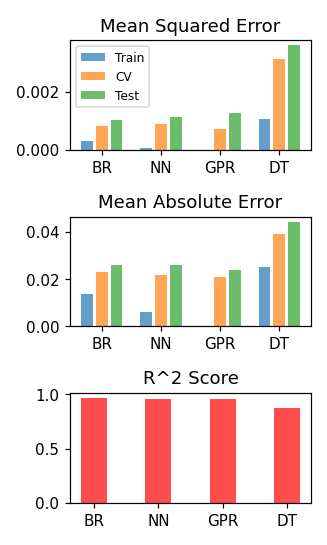

In [18]:
mse_train_values = [mean_squared_error(y_train, predict_train),
                    mean_squared_error(y_train, predict_train2),
                    mean_squared_error(y_train, predict_train3),
                    mean_squared_error(y_train, predict_train4)]

mse_cv_values = [mean_squared_error(y_cv, predict_cv),
                 mean_squared_error(y_cv, predict_cv2),
                 mean_squared_error(y_cv, predict_cv3),
                 mean_squared_error(y_cv, predict_cv4)]

mse_test_values = [mean_squared_error(y_test, predict_test),
                   mean_squared_error(y_test, predict_test2),
                   mean_squared_error(y_test, predict_test3),
                   mean_squared_error(y_test, predict_test4)]

mae_train_values = [mean_absolute_error(y_train, predict_train),
                    mean_absolute_error(y_train, predict_train2),
                    mean_absolute_error(y_train, predict_train3),
                    mean_absolute_error(y_train, predict_train4)]

mae_cv_values = [mean_absolute_error(y_cv, predict_cv),
                 mean_absolute_error(y_cv, predict_cv2),
                 mean_absolute_error(y_cv, predict_cv3),
                 mean_absolute_error(y_cv, predict_cv4)]

mae_test_values = [mean_absolute_error(y_test, predict_test),
                   mean_absolute_error(y_test, predict_test2),
                   mean_absolute_error(y_test, predict_test3),
                   mean_absolute_error(y_test, predict_test4)]

r2_values = [r2_score(y_test, predict_test),
             r2_score(y_test, predict_test2),
             r2_score(y_test, predict_test3),
             r2_score(y_test, predict_test4)]

# define subfigures
fig, axs = plt.subplots(3, 1, figsize=(3, 5))

# MSE plots
axs[0].bar(np.arange(len(mse_train_values)), mse_train_values, width=0.2, label='Train', align='center', alpha=0.7)
axs[0].bar(np.arange(len(mse_cv_values)) + 0.25, mse_cv_values, width=0.2, label='CV', align='center', alpha=0.7)
axs[0].bar(np.arange(len(mse_test_values)) + 0.5, mse_test_values, width=0.2, label='Test', align='center', alpha=0.7)
axs[0].set_title('Mean Squared Error')
axs[0].set_xticks(np.arange(len(mse_train_values)) + 0.25)
axs[0].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
axs[0].legend(fontsize=8)

# MAE plots
axs[1].bar(np.arange(len(mae_train_values)), mae_train_values, width=0.2, label='Train', align='center', alpha=0.7)
axs[1].bar(np.arange(len(mae_cv_values)) + 0.25, mae_cv_values, width=0.2, label='CV', align='center', alpha=0.7)
axs[1].bar(np.arange(len(mae_test_values)) + 0.5, mae_test_values, width=0.2, label='Test', align='center', alpha=0.7)
axs[1].set_title('Mean Absolute Error')
axs[1].set_xticks(np.arange(len(mae_train_values)) + 0.25)
axs[1].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
# axs[1].legend(fontsize=10)

# R^2 plots
axs[2].bar(np.arange(len(r2_values)), r2_values, width=0.4, align='center', alpha=0.7, color = 'red')
axs[2].set_title('R^2 Score')
axs[2].set_xticks(np.arange(len(r2_values)))
axs[2].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])

# adjust layout
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


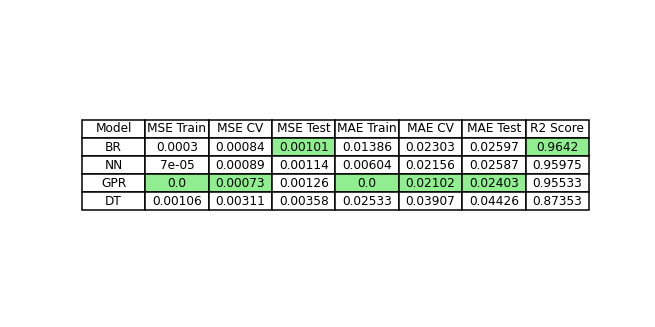

In [21]:
data = {
    'Model': ['BR', 'NN', 'GPR', 'DT'],
    'MSE Train': mse_train_values,
    'MSE CV': mse_cv_values,
    'MSE Test': mse_test_values,
    'MAE Train': mae_train_values,
    'MAE CV': mae_cv_values,
    'MAE Test': mae_test_values,
    'R2 Score': r2_values
}

df = pd.DataFrame(data)

# table 
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.round(5).values, colLabels=df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)

min_values = df.drop(columns='R2 Score').apply(min)
max_r2 = df['R2 Score'].max()

for col in df.columns[1:]:
    if col != 'R2 Score':
        min_val = min_values[col]
        min_index = df[df[col] == min_val].index[0]
        table[(min_index + 1, df.columns.get_loc(col))].set_facecolor('lightgreen')  
    else:
        max_index = df[df[col] == max_r2].index[0]
        table[(max_index + 1, df.columns.get_loc(col))].set_facecolor('lightgreen')  # plus 1 for the title row


plt.show()

<IPython.core.display.Javascript object>


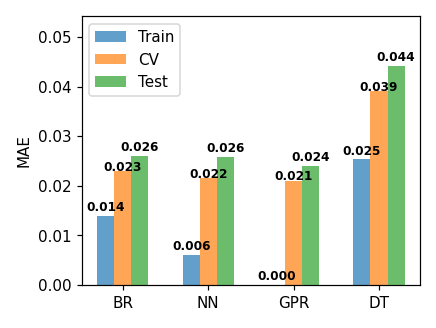

In [20]:
# Plotting the MAE values
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Bar plot positions
x = np.arange(len(mae_train_values))
width = 0.2

# MAE bar plots for Train, CV, and Test
ax.bar(x - width, mae_train_values, width=width, label='Train', align='center', alpha=0.7)
ax.bar(x, mae_cv_values, width=width, label='CV', align='center', alpha=0.7)
ax.bar(x + width, mae_test_values, width=width, label='Test', align='center', alpha=0.7)

# Set y-axis limit to the maximum MAE value + 0.1
max_value = max(mae_train_values + mae_cv_values + mae_test_values)
ax.set_ylim(0, max_value + 0.01)

# Adding titles and labels
# ax.set_title('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
ax.set_ylabel('MAE')
ax.legend(fontsize=10)

# Annotating each bar with the MAE values
for i, (train, cv, test) in enumerate(zip(mae_train_values, mae_cv_values, mae_test_values)):
    ax.text(i - width, train + 0.001, f"{train:.3f}", ha='center', fontsize=8, fontweight='bold')
    ax.text(i, cv + 0.0001, f"{cv:.3f}", ha='center',  fontsize=8, fontweight='bold')
    ax.text(i + width, test + 0.001, f"{test:.3f}", ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()